## Задание
1. Выбрать набор данных (датасет), содержащий категориальные и числовые признаки и пропуски в данных. Для выполнения следующих пунктов можно использовать несколько различных наборов данных (один для обработки пропусков, другой для категориальных признаков и т.д.) Просьба не использовать датасет, на котором данная задача решалась в лекции.
2. Для выбранного датасета (датасетов) на основе материалов лекций решить следующие задачи:
    1. устранение пропусков в данных;
    2. кодирование категориальных признаков
    3. нормализация числовых признаков
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from IPython.display import Image

In [2]:
df = pd.read_csv("titles.csv")
print(df.shape)

(5850, 15)


## Удаление пропусков

In [3]:
list(zip(df.columns, [i for i in df.dtypes]))

[('id', dtype('O')),
 ('title', dtype('O')),
 ('type', dtype('O')),
 ('description', dtype('O')),
 ('release_year', dtype('int64')),
 ('age_certification', dtype('O')),
 ('runtime', dtype('int64')),
 ('genres', dtype('O')),
 ('production_countries', dtype('O')),
 ('seasons', dtype('float64')),
 ('imdb_id', dtype('O')),
 ('imdb_score', dtype('float64')),
 ('imdb_votes', dtype('float64')),
 ('tmdb_popularity', dtype('float64')),
 ('tmdb_score', dtype('float64'))]

In [4]:
nulls = [col for col in df.columns if df[col].isnull().sum() > 0]
nulls_count_by_column = [(c, df[c].isnull().sum()) for c in nulls]
nulls_count_by_column

[('title', 1),
 ('description', 18),
 ('age_certification', 2619),
 ('seasons', 3744),
 ('imdb_id', 403),
 ('imdb_score', 482),
 ('imdb_votes', 498),
 ('tmdb_popularity', 91),
 ('tmdb_score', 311)]

In [5]:
[(c, round(df[c].isnull().mean()*100, 2).__str__()+'%') for c in nulls]

[('title', '0.02%'),
 ('description', '0.31%'),
 ('age_certification', '44.77%'),
 ('seasons', '64.0%'),
 ('imdb_id', '6.89%'),
 ('imdb_score', '8.24%'),
 ('imdb_votes', '8.51%'),
 ('tmdb_popularity', '1.56%'),
 ('tmdb_score', '5.32%')]

In [6]:
hcols_with_na_temp = ['age_certification', 'seasons']
df_new = df[hcols_with_na_temp].dropna()
print(df_new.shape)
print(df.shape)

(1851, 2)
(5850, 15)


### График разницы между распределениями до и после устранения пропусков

In [7]:
def plot_hist_diff(old_ds, new_ds, cols):
    """
    Разница между распределениями до и после устранения пропусков
    """
    for c in cols:   
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.title.set_text('Поле - ' + str(c))
        old_ds[c].hist(bins=50, ax=ax, density=True, color='green')
        new_ds[c].hist(bins=50, ax=ax, color='blue', density=True, alpha=0.5)
        plt.show()

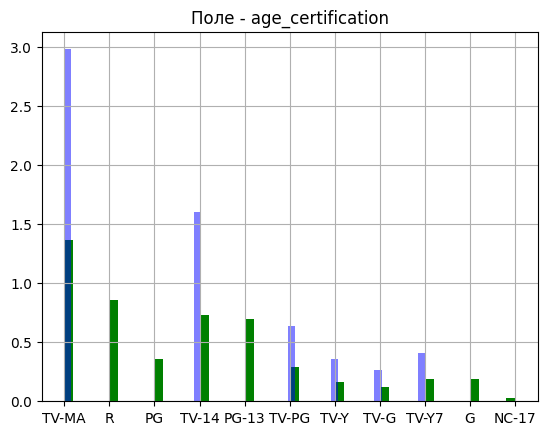

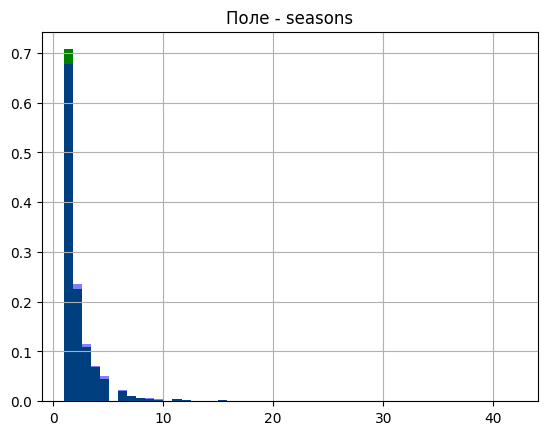

In [8]:
plot_hist_diff(df, df_new, hcols_with_na_temp)

### MissingIndicator

In [9]:
df = pd.read_csv("titles.csv")
print(df.shape)

(5850, 15)


In [10]:
def head_null(df : pd.DataFrame, count=5):
    res = pd.DataFrame(columns=df.columns)
    for row in df.values:
        if len(res) >= count:
            break
        if (False in pd.notna(row)):
            res.loc[len(res.index)] = row
    return res

In [11]:
temp_x1 = head_null(df, 5).to_numpy()
temp_x1

array([['ts300399', 'Five Came Back: The Reference Films', 'SHOW',
        'This collection includes 12 World War II-era propaganda films — many of which are graphic and offensive — discussed in the docuseries "Five Came Back."',
        1945, 'TV-MA', 51, "['documentation']", "['US']", 1.0, nan, nan,
        nan, 0.6, nan],
       ['tm84618', 'Taxi Driver', 'MOVIE',
        'A mentally unstable Vietnam War veteran works as a night-time taxi driver in New York City where the perceived decadence and sleaze feed his urge for violent action.',
        1976, 'R', 114, "['drama', 'crime']", "['US']", nan, 'tt0075314',
        8.2, 808582.0, 40.965, 8.179],
       ['tm154986', 'Deliverance', 'MOVIE',
        "Intent on seeing the Cahulawassee River before it's turned into one huge lake, outdoor fanatic Lewis Medlock takes his friends on a river-rafting trip they'll never forget into the dangerous American back-country.",
        1972, 'R', 109, "['drama', 'action', 'thriller', 'european']",


In [12]:
indicator = MissingIndicator()
temp_x1_transformed = indicator.fit_transform(temp_x1)
print(temp_x1_transformed)

[[False False  True  True  True  True]
 [False  True False False False False]
 [False  True False False False False]
 [False  True False False False False]
 [ True  True False False False False]]


In [13]:
def impute_column(dataset, column, strategy_param, fill_value_param=None):
    """
    Заполнение пропусков в одном признаке
    """
    temp_data = dataset[[column]].values
    size = temp_data.shape[0]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imputer = SimpleImputer(strategy=strategy_param, 
                            fill_value=fill_value_param)
    all_data = imputer.fit_transform(temp_data)
    
    missed_data = temp_data[mask_missing_values_only]
    filled_data = all_data[mask_missing_values_only]
    
    return all_data.reshape((size,)), filled_data, missed_data

In [14]:
all_data, filled_data, missed_data = impute_column(df, 'imdb_score', 'mean')

In [15]:
print('all data len {}'.format(len(all_data)))

print("""filled cell count {}, value to filled {}""".format(len(filled_data), filled_data[0]))

print('missed_data len {}'.format(len(missed_data)))

all data len 5850
filled cell count 482, value to filled 6.510860655737705
missed_data len 482


In [16]:
def research_impute_numeric_column(dataset, num_column, const_value=None):
    strategy_params = ['mean', 'median', 'most_frequent', 'constant']
    strategy_params_names = ['Среднее', 'Медиана', 'Мода']
    strategy_params_names.append('Константа = ' + str(const_value))
    
    original_temp_data = dataset[[num_column]].values
    size = original_temp_data.shape[0]
    original_data = original_temp_data.reshape((size,))
    
    new_df = pd.DataFrame({'Исходные данные':original_data})
       
    for i in range(len(strategy_params)):
        strategy = strategy_params[i]
        col_name = strategy_params_names[i]
        if (strategy!='constant') or (strategy == 'constant' and const_value!=None):
            if strategy == 'constant':
                temp_data, _, _ = impute_column(dataset, num_column, strategy, fill_value_param=const_value)
            else:
                temp_data, _, _ = impute_column(dataset, num_column, strategy)
            new_df[col_name] = temp_data
        
    sns.kdeplot(data=new_df)

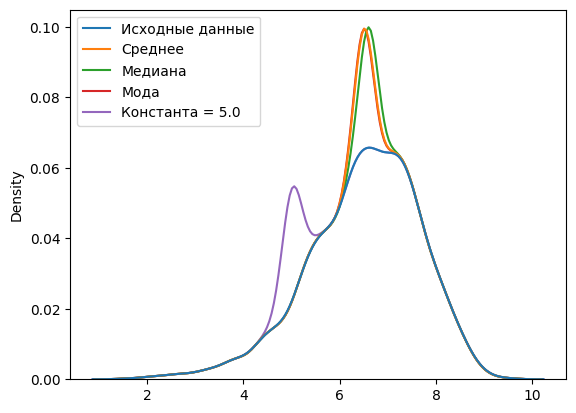

In [17]:
research_impute_numeric_column(df, 'imdb_score', 5.0)

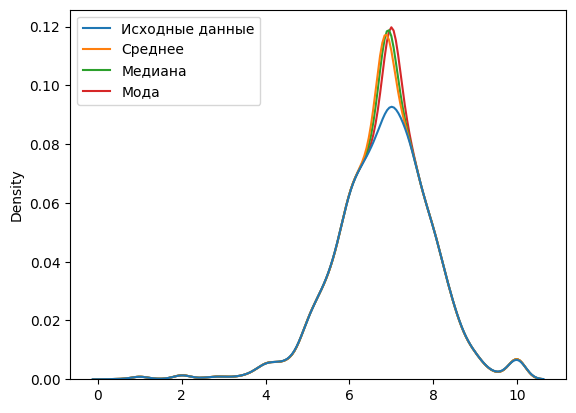

In [18]:
research_impute_numeric_column(df, 'tmdb_score')

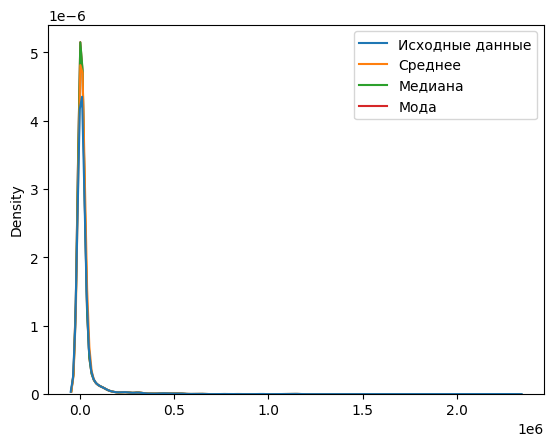

In [19]:
research_impute_numeric_column(df, 'imdb_votes')

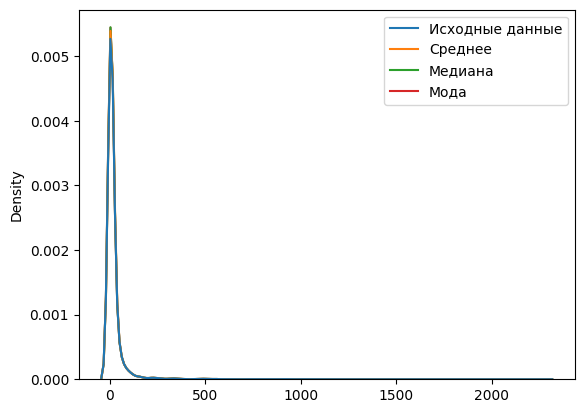

In [20]:
research_impute_numeric_column(df, 'tmdb_popularity')

### Заполнение пропусков
заполнять будем наибоолее распроостраненным значением, так как пропуски распределены не случайно

In [21]:
df_cat_cols = ['imdb_score', 'tmdb_score']
df_cat_new = df[df_cat_cols].copy()

imdb_score_cat_new_temp, _, _ = impute_column(df_cat_new, 'imdb_score', 'most_frequent')
tmdb_score_cat_new_temp, _, _ = impute_column(df_cat_new, 'tmdb_score', 'most_frequent')

df_cat_new['imdb_score'] = imdb_score_cat_new_temp
df_cat_new['imdb_votes'] = tmdb_score_cat_new_temp

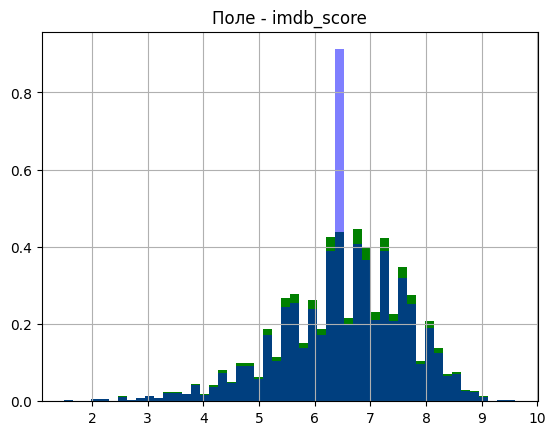

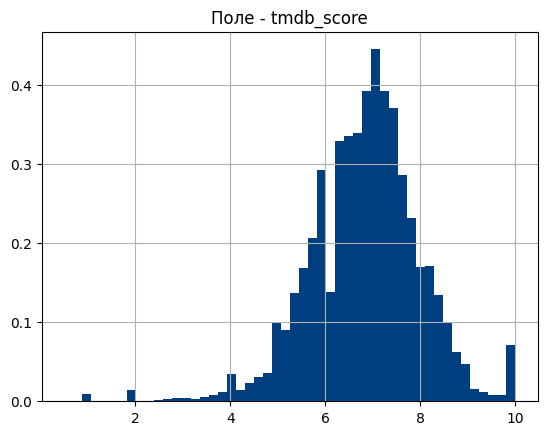

In [22]:
plot_hist_diff(df, df_cat_new, df_cat_cols)

## Кодирование категориальных признакоов

In [23]:
df = pd.read_csv("titles.csv")
print(df.shape)
df.isnull().sum()

(5850, 15)


id                         0
title                      1
type                       0
description               18
release_year               0
age_certification       2619
runtime                    0
genres                     0
production_countries       0
seasons                 3744
imdb_id                  403
imdb_score               482
imdb_votes               498
tmdb_popularity           91
tmdb_score               311
dtype: int64

In [24]:
df.drop(['age_certification', 'seasons'], axis=1, inplace=True)
df.isnull().sum()

id                        0
title                     1
type                      0
description              18
release_year              0
runtime                   0
genres                    0
production_countries      0
imdb_id                 403
imdb_score              482
imdb_votes              498
tmdb_popularity          91
tmdb_score              311
dtype: int64

In [25]:
def impute_na(df, variable, value):
    df[variable].fillna(value, inplace=True)

In [26]:
# Заполним пропуски возраста средними значениями
impute_na(df, 'imdb_score', df['imdb_score'].mean())
impute_na(df, 'imdb_votes', df['imdb_votes'].mean())
impute_na(df, 'tmdb_popularity', df['tmdb_popularity'].mean())
impute_na(df, 'tmdb_score', df['tmdb_score'].mean())

df.dropna(inplace=True)

In [27]:
df.isnull().sum()

id                      0
title                   0
type                    0
description             0
release_year            0
runtime                 0
genres                  0
production_countries    0
imdb_id                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
le = LabelEncoder()
cat_enc_le = le.fit_transform(df['type'])

In [30]:
df['type'].unique()

array(['MOVIE', 'SHOW'], dtype=object)

In [31]:
np.unique(cat_enc_le)

array([0, 1])

In [32]:
le.inverse_transform([0, 1])

array(['MOVIE', 'SHOW'], dtype=object)

## Нормализация числовых признаков

In [33]:
import scipy.stats as stats

def diagnostic_plots(df, variable):
    plt.figure(figsize=(15,6))
    # гистограмма
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    ## Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

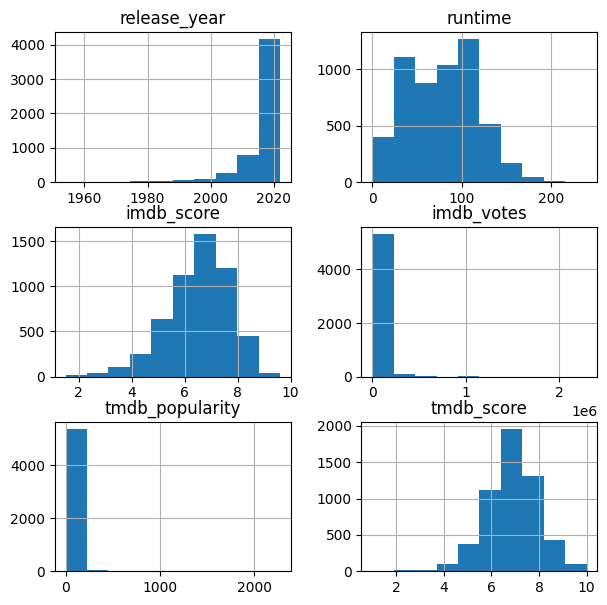

In [34]:
df.hist(figsize=(7,7))
plt.show()

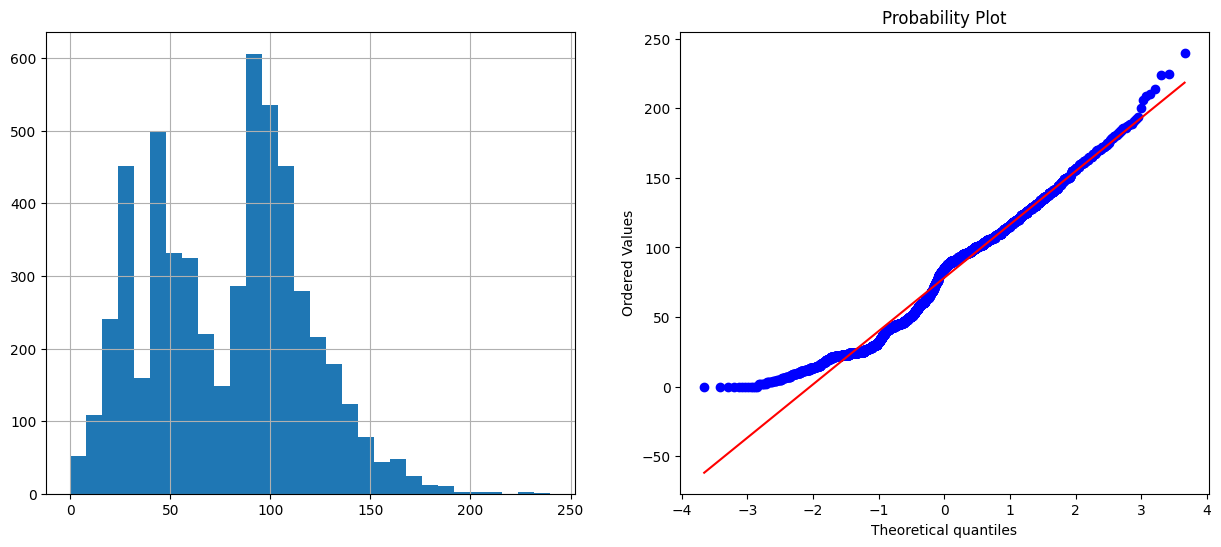

In [35]:
diagnostic_plots(df, 'runtime')

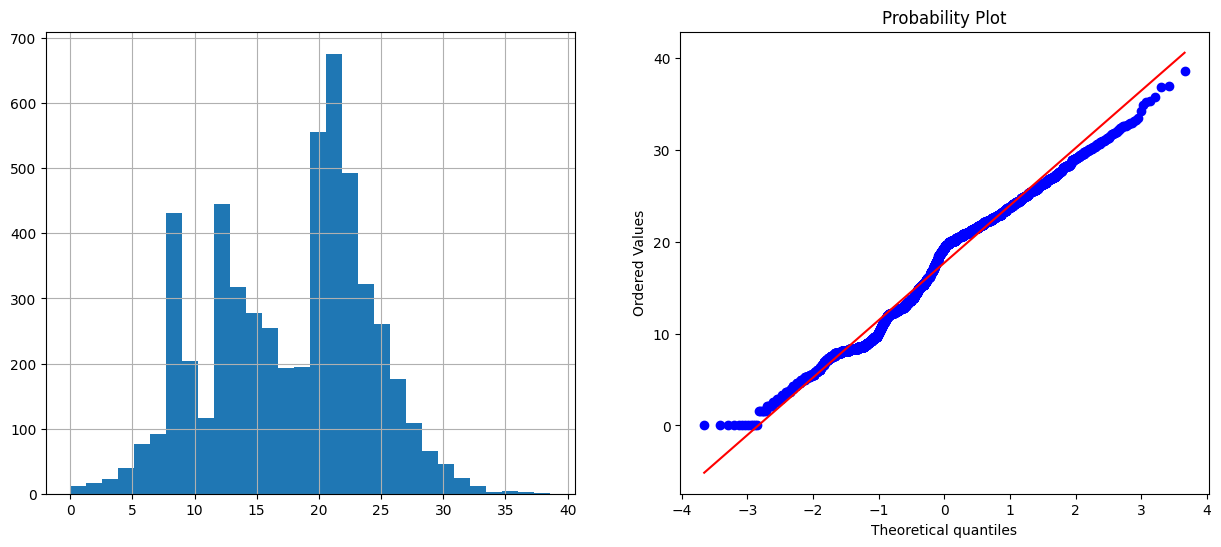

In [36]:
df['runtime_sqr'] = df['runtime']**(1/1.5)
diagnostic_plots(df, 'runtime_sqr')